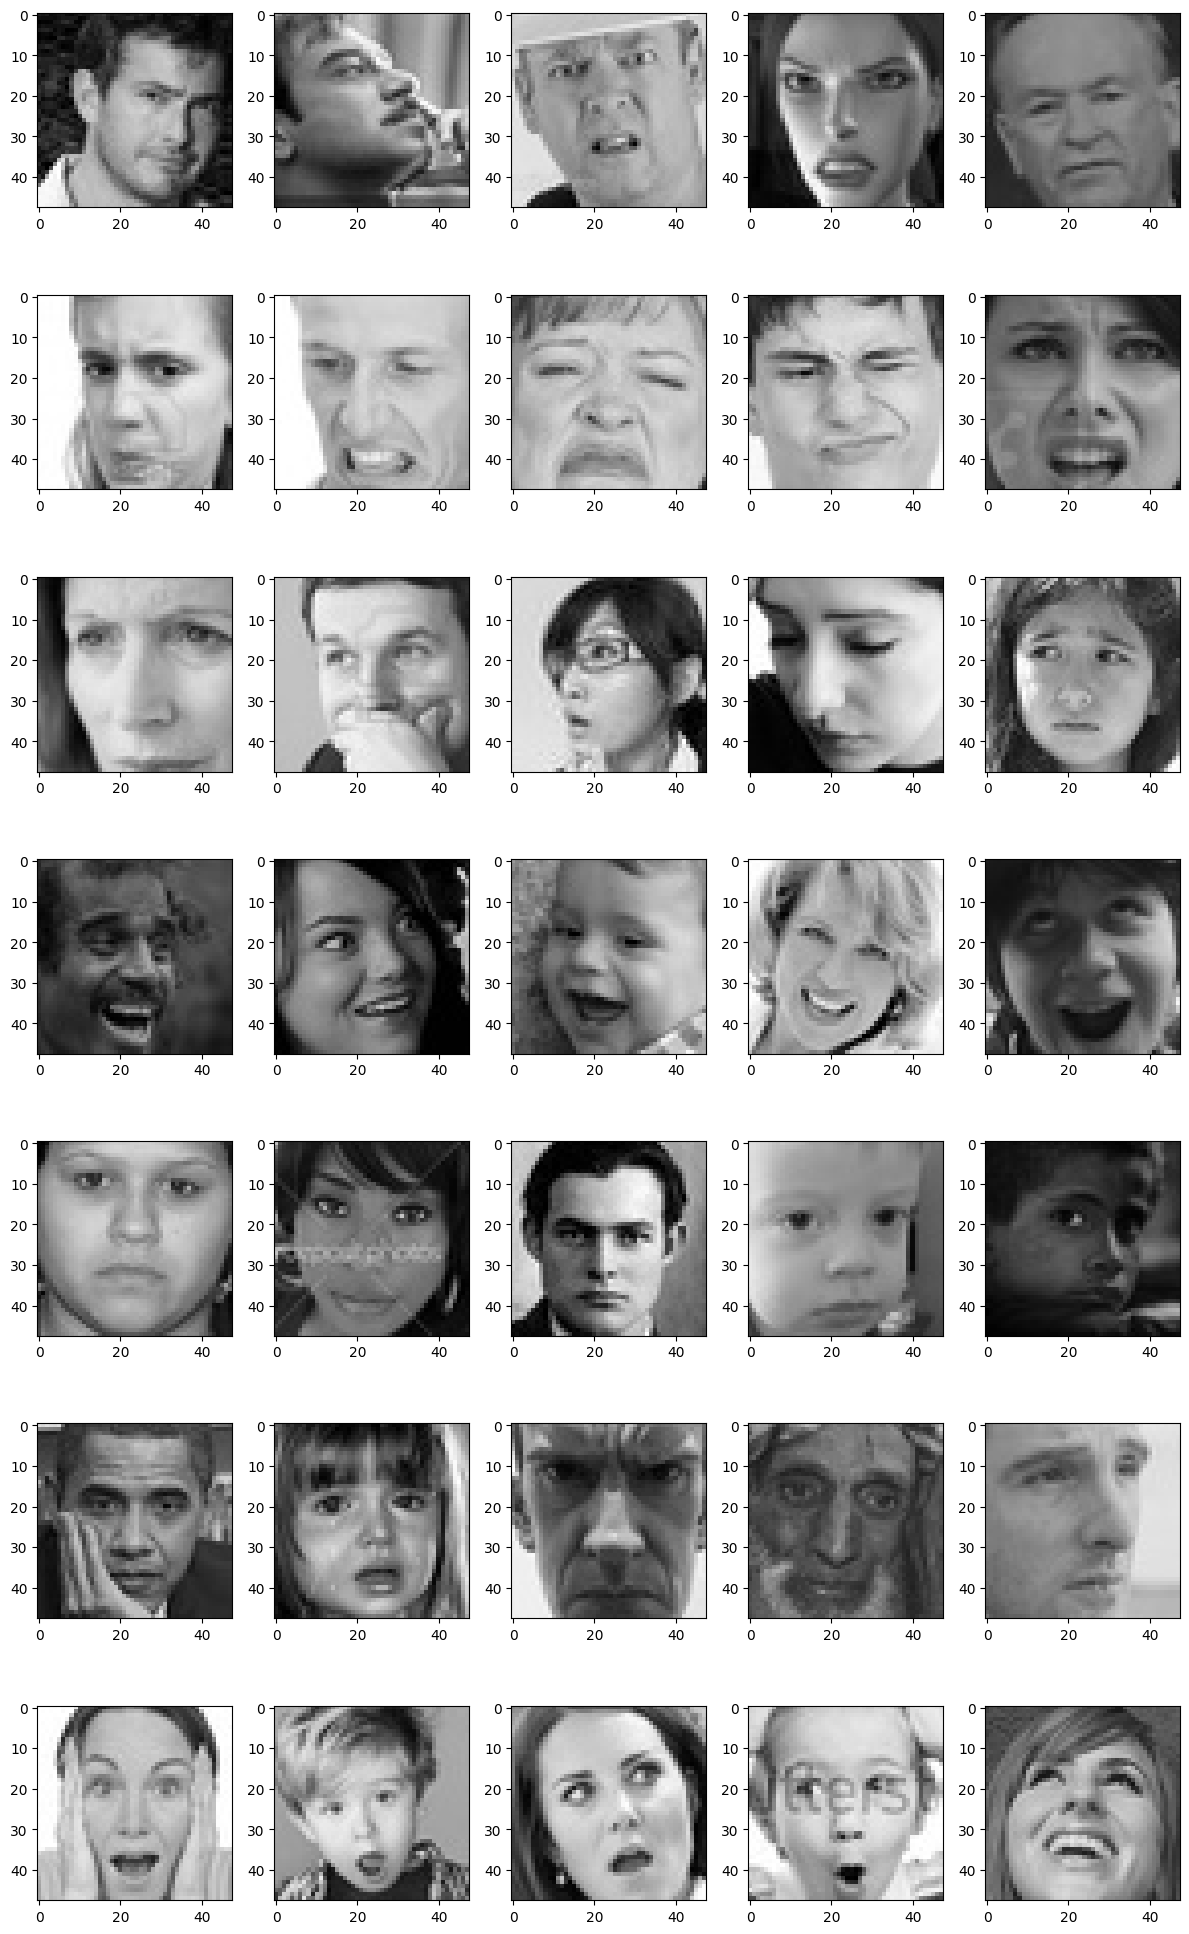

In [1]:
# display some images for every different expression
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "Dataset/FER2013/"

#drop the image with pixel intensity diribustion equal to 0 and show the number of images removed
def drop_zero_intensity_images(base_path):
    for expression in os.listdir(base_path + "train/"):
        files = os.listdir(base_path + "train/" + expression)
        for file in files:
            img = load_img(base_path + "train/" + expression + "/" + file, target_size=(pic_size, pic_size))
            img_array = img_to_array(img)
            if np.sum(img_array) == 0:
                os.remove(base_path + "train/" + expression + "/" + file)
                print(f"Removed image: {file} from {expression}")

drop_zero_intensity_images(base_path)

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()



In [3]:
# count number of train images for each expression

for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

3988 angry images
436 disgust images
4097 fear images
7214 happy images
4964 neutral images
4829 sad images
3170 surprise images


# Data Preparation

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "test",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28698 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Modeling

## Model Inplementation

In [22]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(learning_rate = 0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model Tranning (100 Epochs)

In [7]:
%%time

# number of epochs to train the NN
epochs = 100

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    epochs=epochs,
                    validation_data = validation_generator,
                    validation_steps = validation_generator.n//validation_generator.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.4436 - loss: 1.4608
Epoch 1: val_accuracy improved from -inf to 0.46777, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 637ms/step - accuracy: 0.4436 - loss: 1.4608 - val_accuracy: 0.4678 - val_loss: 1.3921
Epoch 2/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:14 602ms/step - accuracy: 0.5234 - loss: 1.3301
Epoch 2: val_accuracy did not improve from 0.46777
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5234 - loss: 1.3301 - val_accuracy: 0.4675 - val_loss: 1.3938
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.4520 - loss: 1.4240
Epoch 3: val_accuracy improved from 0.46777 to 0.48577, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 639ms/step - accuracy: 0.4520 - loss: 1.4239 - val_accuracy: 0.4858 - val_loss: 1.3257
Epoch 4/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:11 588ms/step - accuracy: 0.4297 - loss: 1.3632
Epoch 4: val_accuracy did not improve from 0.48577
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4297 - loss: 1.3632 - val_accuracy: 0.4845 - val_loss: 1.3280
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.4703 - loss: 1.3827
Epoch 5: val_accuracy improved from 0.48577 to 0.49414, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 145s 649ms/step - accuracy: 0.4703 - loss: 1.3827 - val_accuracy: 0.4941 - val_loss: 1.3232
Epoch 6/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:12 592ms/step - accuracy: 0.4844 - loss: 1.4187
Epoch 6: val_accuracy did not improve from 0.49414
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.4844 - loss: 1.4187 - val_accuracy: 0.4939 - val_loss: 1.3193
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.4765 - loss: 1.3672
Epoch 7: val_accuracy improved from 0.49414 to 0.51493, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 144s 641ms/step - accuracy: 0.4765 - loss: 1.3671 - val_accuracy: 0.5149 - val_loss: 1.2682
Epoch 8/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:13 599ms/step - accuracy: 0.5234 - loss: 1.1745
Epoch 8: val_accuracy did not improve from 0.51493
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5234 - loss: 1.1745 - val_accuracy: 0.5142 - val_loss: 1.2696
Epoch 9/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.5013 - loss: 1.3143
Epoch 9: val_accuracy improved from 0.51493 to 0.51562, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 641ms/step - accuracy: 0.5013 - loss: 1.3143 - val_accuracy: 0.5156 - val_loss: 1.2593
Epoch 10/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:10 587ms/step - accuracy: 0.4609 - loss: 1.3428
Epoch 10: val_accuracy did not improve from 0.51562
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4609 - loss: 1.3428 - val_accuracy: 0.5156 - val_loss: 1.2604
Epoch 11/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.5061 - loss: 1.2915
Epoch 11: val_accuracy did not improve from 0.51562
224/224 ━━━━━━━━━━━━━━━━━━━━ 142s 635ms/step - accuracy: 0.5062 - loss: 1.2915 - val_accuracy: 0.5117 - val_loss: 1.2916
Epoch 12/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:12 596ms/step - accuracy: 0.6328 - loss: 1.1723
Epoch 12: val_accuracy improved from 0.51562 to 0.51604, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6328 - loss: 1.1723 - val_accuracy: 0.5160 - val_loss: 1.2794
Epoch 13/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.5253 - loss: 1.2503
Epoch 13: val_accuracy improved from 0.51604 to 0.53069, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 652ms/step - accuracy: 0.5253 - loss: 1.2503 - val_accuracy: 0.5307 - val_loss: 1.2289
Epoch 14/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:11 591ms/step - accuracy: 0.4922 - loss: 1.2971
Epoch 14: val_accuracy improved from 0.53069 to 0.53278, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.4922 - loss: 1.2971 - val_accuracy: 0.5328 - val_loss: 1.2290
Epoch 15/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.5338 - loss: 1.2180
Epoch 15: val_accuracy improved from 0.53278 to 0.54994, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 142s 635ms/step - accuracy: 0.5338 - loss: 1.2180 - val_accuracy: 0.5499 - val_loss: 1.1810
Epoch 16/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:10 584ms/step - accuracy: 0.5156 - loss: 1.2747
Epoch 16: val_accuracy did not improve from 0.54994
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5156 - loss: 1.2747 - val_accuracy: 0.5495 - val_loss: 1.1820
Epoch 17/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.5385 - loss: 1.2111
Epoch 17: val_accuracy did not improve from 0.54994
224/224 ━━━━━━━━━━━━━━━━━━━━ 142s 635ms/step - accuracy: 0.5385 - loss: 1.2111 - val_accuracy: 0.5389 - val_loss: 1.2021
Epoch 18/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:09 580ms/step - accuracy: 0.4766 - loss: 1.2613
Epoch 18: val_accuracy did not improve from 0.54994
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.4766 - loss: 1.2613 - val_accuracy: 0.5473 - val_loss: 1.1852
Epoch 19/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.5582 - loss: 1.1771


224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 638ms/step - accuracy: 0.5601 - loss: 1.1636 - val_accuracy: 0.5604 - val_loss: 1.1474
Epoch 22/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:09 580ms/step - accuracy: 0.5859 - loss: 1.0358
Epoch 22: val_accuracy did not improve from 0.56041
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5859 - loss: 1.0358 - val_accuracy: 0.5596 - val_loss: 1.1489
Epoch 23/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.5671 - loss: 1.1470
Epoch 23: val_accuracy improved from 0.56041 to 0.56822, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 640ms/step - accuracy: 0.5671 - loss: 1.1470 - val_accuracy: 0.5682 - val_loss: 1.1277
Epoch 24/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:11 590ms/step - accuracy: 0.5859 - loss: 1.0829
Epoch 24: val_accuracy did not improve from 0.56822
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5859 - loss: 1.0829 - val_accuracy: 0.5670 - val_loss: 1.1308
Epoch 25/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.5715 - loss: 1.1204
Epoch 25: val_accuracy improved from 0.56822 to 0.56850, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 640ms/step - accuracy: 0.5715 - loss: 1.1205 - val_accuracy: 0.5685 - val_loss: 1.1250
Epoch 26/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:10 584ms/step - accuracy: 0.4922 - loss: 1.1267
Epoch 26: val_accuracy improved from 0.56850 to 0.57143, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4922 - loss: 1.1267 - val_accuracy: 0.5714 - val_loss: 1.1224
Epoch 27/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.5838 - loss: 1.1091
Epoch 27: val_accuracy improved from 0.57143 to 0.57910, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 142s 635ms/step - accuracy: 0.5838 - loss: 1.1091 - val_accuracy: 0.5791 - val_loss: 1.1189
Epoch 28/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:14 603ms/step - accuracy: 0.5938 - loss: 0.9832
Epoch 28: val_accuracy did not improve from 0.57910
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5938 - loss: 0.9832 - val_accuracy: 0.5783 - val_loss: 1.1220
Epoch 29/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.5870 - loss: 1.0871
Epoch 29: val_accuracy improved from 0.57910 to 0.58454, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 637ms/step - accuracy: 0.5870 - loss: 1.0871 - val_accuracy: 0.5845 - val_loss: 1.1024
Epoch 30/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:14 601ms/step - accuracy: 0.5469 - loss: 1.2015
Epoch 30: val_accuracy improved from 0.58454 to 0.58482, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5469 - loss: 1.2015 - val_accuracy: 0.5848 - val_loss: 1.1050
Epoch 31/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.5996 - loss: 1.0573
Epoch 31: val_accuracy improved from 0.58482 to 0.58998, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 638ms/step - accuracy: 0.5996 - loss: 1.0573 - val_accuracy: 0.5900 - val_loss: 1.0888
Epoch 32/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:16 614ms/step - accuracy: 0.5000 - loss: 1.1637
Epoch 32: val_accuracy improved from 0.58998 to 0.59138, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5000 - loss: 1.1637 - val_accuracy: 0.5914 - val_loss: 1.0854
Epoch 33/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.5997 - loss: 1.0495
Epoch 33: val_accuracy did not improve from 0.59138
224/224 ━━━━━━━━━━━━━━━━━━━━ 144s 642ms/step - accuracy: 0.5997 - loss: 1.0495 - val_accuracy: 0.5912 - val_loss: 1.0980
Epoch 34/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:14 601ms/step - accuracy: 0.6016 - loss: 1.0678
Epoch 34: val_accuracy improved from 0.59138 to 0.59263, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6016 - loss: 1.0678 - val_accuracy: 0.5926 - val_loss: 1.0959
Epoch 35/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.6063 - loss: 1.0300
Epoch 35: val_accuracy did not improve from 0.59263
224/224 ━━━━━━━━━━━━━━━━━━━━ 144s 641ms/step - accuracy: 0.6063 - loss: 1.0301 - val_accuracy: 0.5737 - val_loss: 1.1650
Epoch 36/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:11 590ms/step - accuracy: 0.5781 - loss: 1.0786
Epoch 36: val_accuracy did not improve from 0.59263
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5781 - loss: 1.0786 - val_accuracy: 0.5739 - val_loss: 1.1564
Epoch 37/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.6106 - loss: 1.0267
Epoch 37: val_accuracy improved from 0.59263 to 0.60603, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 144s 645ms/step - accuracy: 0.6106 - loss: 1.0267 - val_accuracy: 0.6060 - val_loss: 1.0573
Epoch 38/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:14 603ms/step - accuracy: 0.6172 - loss: 1.0376
Epoch 38: val_accuracy did not improve from 0.60603
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6172 - loss: 1.0376 - val_accuracy: 0.6045 - val_loss: 1.0608
Epoch 39/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.6227 - loss: 1.0005
Epoch 39: val_accuracy did not improve from 0.60603
224/224 ━━━━━━━━━━━━━━━━━━━━ 154s 686ms/step - accuracy: 0.6227 - loss: 1.0005 - val_accuracy: 0.6020 - val_loss: 1.0653
Epoch 40/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:12 596ms/step - accuracy: 0.6094 - loss: 0.9946
Epoch 40: val_accuracy did not improve from 0.60603
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6094 - loss: 0.9946 - val_accuracy: 0.6010 - val_loss: 1.0647
Epoch 41/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.6199 - loss: 0.9989


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 650ms/step - accuracy: 0.6199 - loss: 0.9989 - val_accuracy: 0.6066 - val_loss: 1.0741
Epoch 42/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:10 583ms/step - accuracy: 0.6250 - loss: 1.0473
Epoch 42: val_accuracy did not improve from 0.60658
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.6250 - loss: 1.0473 - val_accuracy: 0.6028 - val_loss: 1.0805
Epoch 43/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.6424 - loss: 0.9568
Epoch 43: val_accuracy did not improve from 0.60658
224/224 ━━━━━━━━━━━━━━━━━━━━ 142s 635ms/step - accuracy: 0.6423 - loss: 0.9569 - val_accuracy: 0.6042 - val_loss: 1.0838
Epoch 44/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:17 616ms/step - accuracy: 0.5781 - loss: 0.9878
Epoch 44: val_accuracy did not improve from 0.60658
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5781 - loss: 0.9878 - val_accuracy: 0.6002 - val_loss: 1.0893
Epoch 45/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.6379 - loss: 0.9539


224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 638ms/step - accuracy: 0.6503 - loss: 0.9349 - val_accuracy: 0.6113 - val_loss: 1.0566
Epoch 48/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:11 591ms/step - accuracy: 0.5625 - loss: 1.0314
Epoch 48: val_accuracy did not improve from 0.61133
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5625 - loss: 1.0314 - val_accuracy: 0.6110 - val_loss: 1.0602
Epoch 49/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.6591 - loss: 0.9175
Epoch 49: val_accuracy improved from 0.61133 to 0.61677, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 653ms/step - accuracy: 0.6591 - loss: 0.9176 - val_accuracy: 0.6168 - val_loss: 1.0639
Epoch 50/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:20 632ms/step - accuracy: 0.6953 - loss: 0.9568
Epoch 50: val_accuracy improved from 0.61677 to 0.61830, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6953 - loss: 0.9568 - val_accuracy: 0.6183 - val_loss: 1.0626
Epoch 51/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.6602 - loss: 0.9021
Epoch 51: val_accuracy did not improve from 0.61830
224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 652ms/step - accuracy: 0.6602 - loss: 0.9021 - val_accuracy: 0.6122 - val_loss: 1.0612
Epoch 52/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:11 588ms/step - accuracy: 0.6797 - loss: 0.8488
Epoch 52: val_accuracy did not improve from 0.61830
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6797 - loss: 0.8488 - val_accuracy: 0.6140 - val_loss: 1.0603
Epoch 53/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.6601 - loss: 0.8990
Epoch 53: val_accuracy did not improve from 0.61830
224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 637ms/step - accuracy: 0.6601 - loss: 0.8990 - val_accuracy: 0.6152 - val_loss: 1.0508
Epoch 54/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:09 581ms/step - accuracy: 0.7188 - loss: 0.8871


224/224 ━━━━━━━━━━━━━━━━━━━━ 142s 636ms/step - accuracy: 0.6754 - loss: 0.8633 - val_accuracy: 0.6225 - val_loss: 1.0558
Epoch 58/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:09 581ms/step - accuracy: 0.6484 - loss: 0.8244
Epoch 58: val_accuracy improved from 0.62249 to 0.62374, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6484 - loss: 0.8244 - val_accuracy: 0.6237 - val_loss: 1.0544
Epoch 59/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.6899 - loss: 0.8291
Epoch 59: val_accuracy improved from 0.62374 to 0.62542, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 144s 641ms/step - accuracy: 0.6899 - loss: 0.8291 - val_accuracy: 0.6254 - val_loss: 1.0351
Epoch 60/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:10 583ms/step - accuracy: 0.6641 - loss: 0.8767
Epoch 60: val_accuracy improved from 0.62542 to 0.62946, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6641 - loss: 0.8767 - val_accuracy: 0.6295 - val_loss: 1.0294
Epoch 61/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.6896 - loss: 0.8280
Epoch 61: val_accuracy improved from 0.62946 to 0.63156, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 144s 641ms/step - accuracy: 0.6896 - loss: 0.8280 - val_accuracy: 0.6316 - val_loss: 1.0254
Epoch 62/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:14 602ms/step - accuracy: 0.7266 - loss: 0.8493
Epoch 62: val_accuracy improved from 0.63156 to 0.63225, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.7266 - loss: 0.8493 - val_accuracy: 0.6323 - val_loss: 1.0243
Epoch 63/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.6899 - loss: 0.8192
Epoch 63: val_accuracy did not improve from 0.63225
224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 640ms/step - accuracy: 0.6899 - loss: 0.8192 - val_accuracy: 0.6286 - val_loss: 1.0441
Epoch 64/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:12 593ms/step - accuracy: 0.7344 - loss: 0.8336
Epoch 64: val_accuracy did not improve from 0.63225
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.7344 - loss: 0.8336 - val_accuracy: 0.6299 - val_loss: 1.0440
Epoch 65/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.7038 - loss: 0.7931
Epoch 65: val_accuracy did not improve from 0.63225
224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 639ms/step - accuracy: 0.7038 - loss: 0.7932 - val_accuracy: 0.6173 - val_loss: 1.0956
Epoch 66/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:10 586ms/step - accuracy: 0.6875 - loss: 0.7954


224/224 ━━━━━━━━━━━━━━━━━━━━ 150s 671ms/step - accuracy: 0.7160 - loss: 0.7623 - val_accuracy: 0.6406 - val_loss: 1.0264
Epoch 72/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - accuracy: 0.6154 - loss: 1.1950
Epoch 72: val_accuracy improved from 0.64062 to 0.64090, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.6154 - loss: 1.1950 - val_accuracy: 0.6409 - val_loss: 1.0267
Epoch 73/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.7276 - loss: 0.7410
Epoch 73: val_accuracy did not improve from 0.64090
224/224 ━━━━━━━━━━━━━━━━━━━━ 155s 691ms/step - accuracy: 0.7276 - loss: 0.7410 - val_accuracy: 0.6409 - val_loss: 1.0379
Epoch 74/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:22 640ms/step - accuracy: 0.7500 - loss: 0.6590
Epoch 74: val_accuracy did not improve from 0.64090
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.7500 - loss: 0.6590 - val_accuracy: 0.6396 - val_loss: 1.0387
Epoch 75/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.7276 - loss: 0.7211
Epoch 75: val_accuracy did not improve from 0.64090
224/224 ━━━━━━━━━━━━━━━━━━━━ 150s 669ms/step - accuracy: 0.7275 - loss: 0.7212 - val_accuracy: 0.6193 - val_loss: 1.0887
Epoch 76/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:18 623ms/step - accuracy: 0.6797 - loss: 0.8179


224/224 ━━━━━━━━━━━━━━━━━━━━ 149s 667ms/step - accuracy: 0.7321 - loss: 0.7112 - val_accuracy: 0.6489 - val_loss: 1.0169
Epoch 78/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:25 651ms/step - accuracy: 0.7031 - loss: 0.7581
Epoch 78: val_accuracy did not improve from 0.64886
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7031 - loss: 0.7581 - val_accuracy: 0.6487 - val_loss: 1.0186
Epoch 79/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.7402 - loss: 0.7017
Epoch 79: val_accuracy did not improve from 0.64886
224/224 ━━━━━━━━━━━━━━━━━━━━ 150s 668ms/step - accuracy: 0.7402 - loss: 0.7017 - val_accuracy: 0.6330 - val_loss: 1.0564
Epoch 80/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:14 604ms/step - accuracy: 0.7500 - loss: 0.6761
Epoch 80: val_accuracy did not improve from 0.64886
224/224 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7500 - loss: 0.6761 - val_accuracy: 0.6325 - val_loss: 1.0594
Epoch 81/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.7457 - loss: 0.6792


## Evaluation Model(100 Epochs)

### Loss and Accuracy

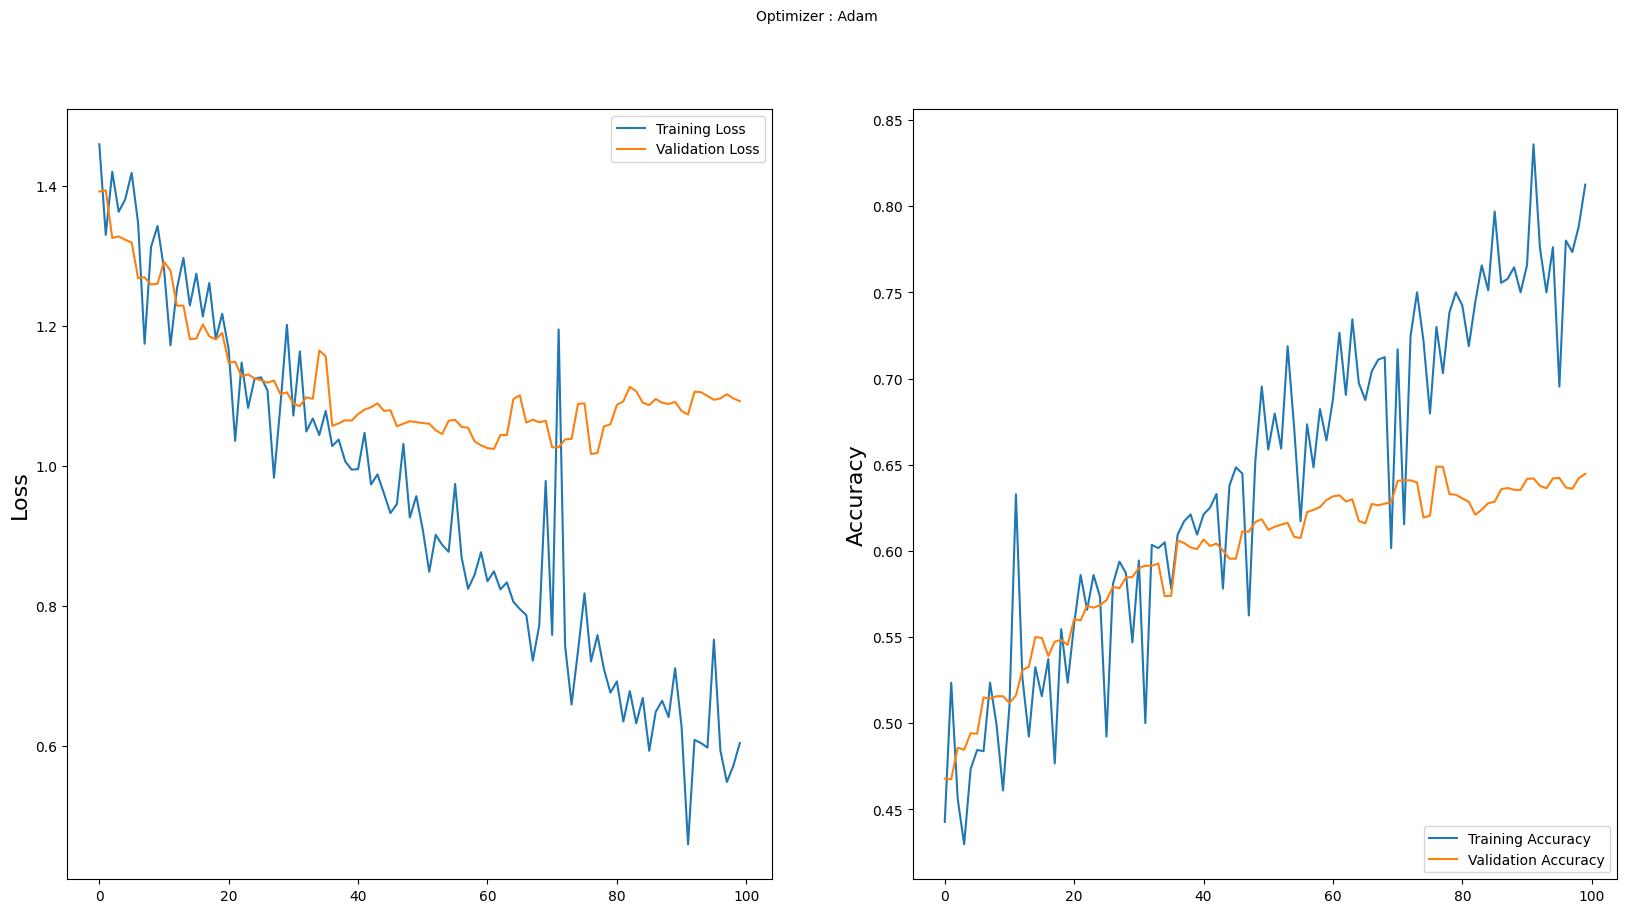

In [8]:
# plot the evolution of Loss and Accuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Updated key
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Updated key
plt.legend(loc='lower right')
plt.show()

### Confusion Matrix and Classification Report

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step
              precision    recall  f1-score   support

       angry       0.63      0.52      0.57       958
     disgust       0.72      0.63      0.67       111
        fear       0.58      0.40      0.47      1024
       happy       0.88      0.79      0.83      1774
     neutral       0.56      0.65      0.60      1233
         sad       0.48      0.59      0.53      1247
    surprise       0.70      0.86      0.77       831

    accuracy                           0.65      7178
   macro avg       0.65      0.63      0.64      7178
weighted avg       0.66      0.65      0.64      7178



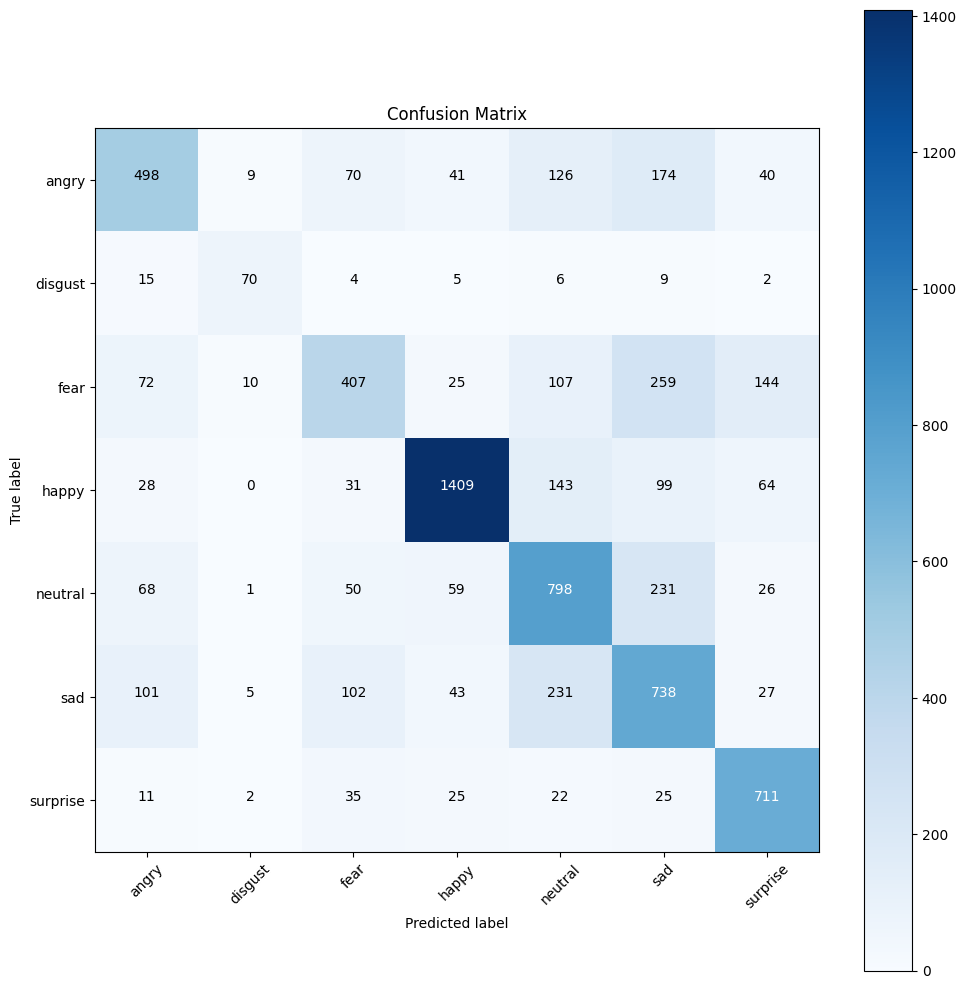

In [ ]:
# compute predictions
predictions = model.predict(validation_generator)  # Use predict instead of predict_generator
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

# plot normal confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

# show the classification report
from sklearn.metrics import classification_report
target_names = list(class_names)
print(classification_report(y_test, y_pred, target_names=target_names))

### Save Model

In [10]:
# save the model
model.save("fer_model.h5")

In [19]:
#load the model
from keras.models import load_model
#model = load_model("fer_model.h5")
model = load_model("BestEmotionsModel.h5")

## Evaluation Best Model

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step
              precision    recall  f1-score   support

       angry       0.56      0.54      0.55       958
     disgust       0.67      0.56      0.61       111
        fear       0.59      0.41      0.48      1024
       happy       0.83      0.84      0.84      1774
     neutral       0.55      0.66      0.60      1233
         sad       0.52      0.55      0.53      1247
    surprise       0.78      0.81      0.79       831

    accuracy                           0.65      7178
   macro avg       0.64      0.62      0.63      7178
weighted avg       0.65      0.65      0.65      7178



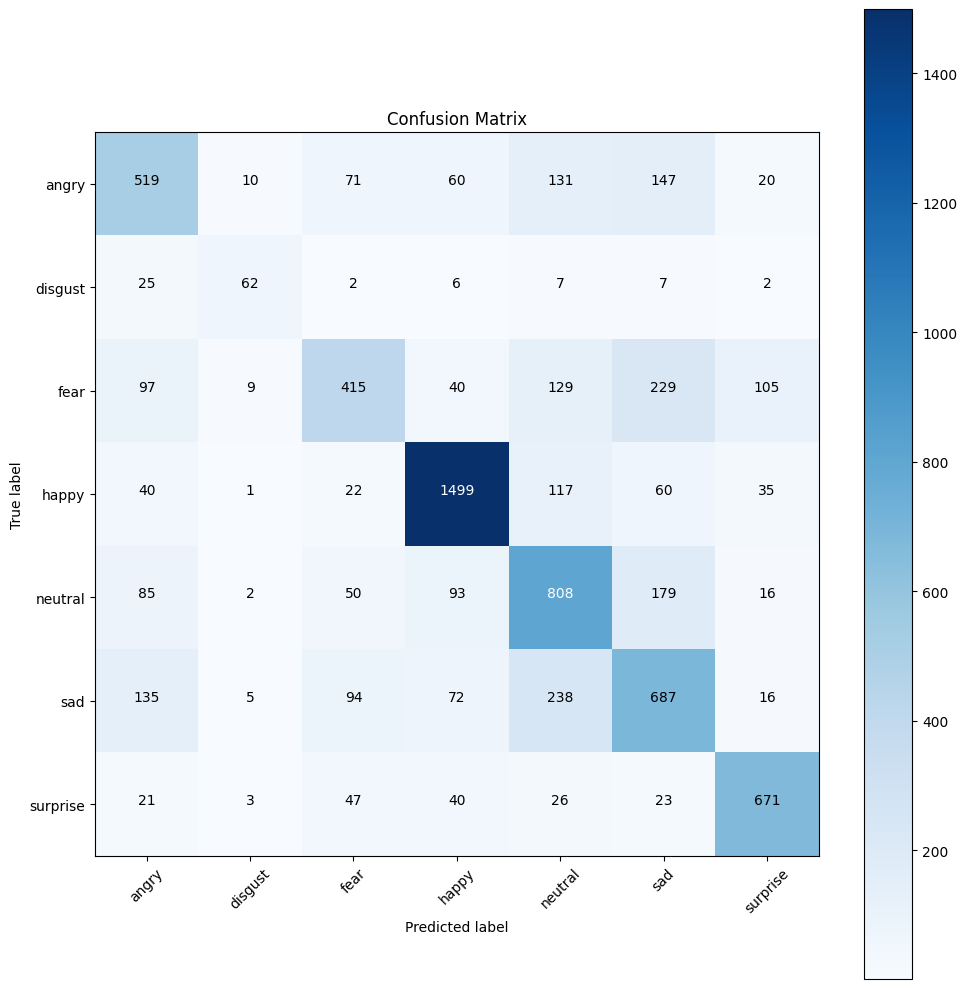

In [21]:
# compute predictions
predictions = model.predict(validation_generator)  # Use predict instead of predict_generator
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

# show the classification report
target_names = list(class_names)
print(classification_report(y_test, y_pred, target_names=target_names))

## Model Training (37 Epochs)

In [23]:
%%time

# number of epochs to train the NN
epochs = 37

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    epochs=epochs,
                    validation_data = validation_generator,
                    validation_steps = validation_generator.n//validation_generator.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.2217 - loss: 2.1181
Epoch 1: val_accuracy improved from -inf to 0.32743, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 208s 912ms/step - accuracy: 0.2217 - loss: 2.1176 - val_accuracy: 0.3274 - val_loss: 1.7160
Epoch 2/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:30 674ms/step - accuracy: 0.2656 - loss: 1.8008

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.32743
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.2656 - loss: 1.8008 - val_accuracy: 0.3256 - val_loss: 1.7157
Epoch 3/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.2813 - loss: 1.8513
Epoch 3: val_accuracy improved from 0.32743 to 0.33970, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 652ms/step - accuracy: 0.2814 - loss: 1.8512 - val_accuracy: 0.3397 - val_loss: 1.6828
Epoch 4/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:13 599ms/step - accuracy: 0.3047 - loss: 1.6998
Epoch 4: val_accuracy did not improve from 0.33970
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.3047 - loss: 1.6998 - val_accuracy: 0.3397 - val_loss: 1.6838
Epoch 5/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.3260 - loss: 1.7464
Epoch 5: val_accuracy improved from 0.33970 to 0.38309, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 147s 656ms/step - accuracy: 0.3260 - loss: 1.7463 - val_accuracy: 0.3831 - val_loss: 1.6147
Epoch 6/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:26 657ms/step - accuracy: 0.3047 - loss: 1.7232
Epoch 6: val_accuracy improved from 0.38309 to 0.38351, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.3047 - loss: 1.7232 - val_accuracy: 0.3835 - val_loss: 1.6117
Epoch 7/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.3645 - loss: 1.6559
Epoch 7: val_accuracy improved from 0.38351 to 0.40374, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 653ms/step - accuracy: 0.3646 - loss: 1.6558 - val_accuracy: 0.4037 - val_loss: 1.5324
Epoch 8/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:18 621ms/step - accuracy: 0.3984 - loss: 1.5688
Epoch 8: val_accuracy did not improve from 0.40374
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.3984 - loss: 1.5688 - val_accuracy: 0.4019 - val_loss: 1.5428
Epoch 9/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.3880 - loss: 1.5865
Epoch 9: val_accuracy improved from 0.40374 to 0.42146, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 652ms/step - accuracy: 0.3880 - loss: 1.5864 - val_accuracy: 0.4215 - val_loss: 1.4931
Epoch 10/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:17 617ms/step - accuracy: 0.3594 - loss: 1.6293
Epoch 10: val_accuracy did not improve from 0.42146
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.3594 - loss: 1.6293 - val_accuracy: 0.4202 - val_loss: 1.5017
Epoch 11/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.4098 - loss: 1.5436
Epoch 11: val_accuracy improved from 0.42146 to 0.43331, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 651ms/step - accuracy: 0.4098 - loss: 1.5435 - val_accuracy: 0.4333 - val_loss: 1.4709
Epoch 12/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:13 598ms/step - accuracy: 0.4453 - loss: 1.6052
Epoch 12: val_accuracy did not improve from 0.43331
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4453 - loss: 1.6052 - val_accuracy: 0.4330 - val_loss: 1.4680
Epoch 13/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.4318 - loss: 1.4883
Epoch 13: val_accuracy improved from 0.43331 to 0.46122, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 651ms/step - accuracy: 0.4317 - loss: 1.4883 - val_accuracy: 0.4612 - val_loss: 1.3962
Epoch 14/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:13 598ms/step - accuracy: 0.4453 - loss: 1.4255
Epoch 14: val_accuracy improved from 0.46122 to 0.46317, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4453 - loss: 1.4255 - val_accuracy: 0.4632 - val_loss: 1.3926
Epoch 15/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.4509 - loss: 1.4386
Epoch 15: val_accuracy improved from 0.46317 to 0.46763, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 653ms/step - accuracy: 0.4509 - loss: 1.4386 - val_accuracy: 0.4676 - val_loss: 1.3693
Epoch 16/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:15 606ms/step - accuracy: 0.4219 - loss: 1.4642
Epoch 16: val_accuracy improved from 0.46763 to 0.46875, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4219 - loss: 1.4642 - val_accuracy: 0.4688 - val_loss: 1.3644
Epoch 17/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.4628 - loss: 1.4036
Epoch 17: val_accuracy improved from 0.46875 to 0.49623, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 652ms/step - accuracy: 0.4628 - loss: 1.4036 - val_accuracy: 0.4962 - val_loss: 1.3147
Epoch 18/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:20 631ms/step - accuracy: 0.4297 - loss: 1.4505
Epoch 18: val_accuracy improved from 0.49623 to 0.49707, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4297 - loss: 1.4505 - val_accuracy: 0.4971 - val_loss: 1.3167
Epoch 19/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.4766 - loss: 1.3595
Epoch 19: val_accuracy did not improve from 0.49707
224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 651ms/step - accuracy: 0.4766 - loss: 1.3595 - val_accuracy: 0.4951 - val_loss: 1.3137
Epoch 20/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:12 593ms/step - accuracy: 0.4062 - loss: 1.4499
Epoch 20: val_accuracy did not improve from 0.49707
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4062 - loss: 1.4499 - val_accuracy: 0.4880 - val_loss: 1.3371
Epoch 21/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.4914 - loss: 1.3263
Epoch 21: val_accuracy improved from 0.49707 to 0.50516, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 652ms/step - accuracy: 0.4914 - loss: 1.3262 - val_accuracy: 0.5052 - val_loss: 1.2966
Epoch 22/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:19 624ms/step - accuracy: 0.5078 - loss: 1.3329
Epoch 22: val_accuracy improved from 0.50516 to 0.50739, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5078 - loss: 1.3329 - val_accuracy: 0.5074 - val_loss: 1.2938
Epoch 23/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.5023 - loss: 1.2967
Epoch 23: val_accuracy improved from 0.50739 to 0.51772, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 651ms/step - accuracy: 0.5023 - loss: 1.2967 - val_accuracy: 0.5177 - val_loss: 1.2590
Epoch 24/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:17 618ms/step - accuracy: 0.5625 - loss: 1.2095
Epoch 24: val_accuracy did not improve from 0.51772
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5625 - loss: 1.2095 - val_accuracy: 0.5127 - val_loss: 1.2708
Epoch 25/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.5181 - loss: 1.2589
Epoch 25: val_accuracy improved from 0.51772 to 0.53613, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 652ms/step - accuracy: 0.5181 - loss: 1.2589 - val_accuracy: 0.5361 - val_loss: 1.2098
Epoch 26/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:19 624ms/step - accuracy: 0.5547 - loss: 1.2125
Epoch 26: val_accuracy did not improve from 0.53613
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5547 - loss: 1.2125 - val_accuracy: 0.5350 - val_loss: 1.2110
Epoch 27/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.5231 - loss: 1.2412
Epoch 27: val_accuracy improved from 0.53613 to 0.53864, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 652ms/step - accuracy: 0.5231 - loss: 1.2412 - val_accuracy: 0.5386 - val_loss: 1.1991
Epoch 28/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:14 605ms/step - accuracy: 0.6016 - loss: 1.1385
Epoch 28: val_accuracy did not improve from 0.53864
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6016 - loss: 1.1385 - val_accuracy: 0.5382 - val_loss: 1.1975
Epoch 29/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.5369 - loss: 1.2201
Epoch 29: val_accuracy improved from 0.53864 to 0.55399, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 145s 649ms/step - accuracy: 0.5369 - loss: 1.2201 - val_accuracy: 0.5540 - val_loss: 1.1705
Epoch 30/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:17 617ms/step - accuracy: 0.6094 - loss: 1.0796
Epoch 30: val_accuracy improved from 0.55399 to 0.55441, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6094 - loss: 1.0796 - val_accuracy: 0.5544 - val_loss: 1.1682
Epoch 31/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.5437 - loss: 1.2012
Epoch 31: val_accuracy did not improve from 0.55441
224/224 ━━━━━━━━━━━━━━━━━━━━ 145s 649ms/step - accuracy: 0.5437 - loss: 1.2011 - val_accuracy: 0.5460 - val_loss: 1.1788
Epoch 32/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:14 604ms/step - accuracy: 0.5703 - loss: 1.1519
Epoch 32: val_accuracy did not improve from 0.55441
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5703 - loss: 1.1519 - val_accuracy: 0.5449 - val_loss: 1.1812
Epoch 33/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.5505 - loss: 1.1794
Epoch 33: val_accuracy improved from 0.55441 to 0.56655, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 651ms/step - accuracy: 0.5505 - loss: 1.1794 - val_accuracy: 0.5665 - val_loss: 1.1348
Epoch 34/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:19 624ms/step - accuracy: 0.5469 - loss: 1.0773
Epoch 34: val_accuracy did not improve from 0.56655
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5469 - loss: 1.0773 - val_accuracy: 0.5664 - val_loss: 1.1354
Epoch 35/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.5626 - loss: 1.1453
Epoch 35: val_accuracy improved from 0.56655 to 0.57073, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 653ms/step - accuracy: 0.5626 - loss: 1.1453 - val_accuracy: 0.5707 - val_loss: 1.1383
Epoch 36/37
  1/224 ━━━━━━━━━━━━━━━━━━━━ 2:16 612ms/step - accuracy: 0.5781 - loss: 1.1235
Epoch 36: val_accuracy improved from 0.57073 to 0.57087, saving model to model_weights.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5781 - loss: 1.1235 - val_accuracy: 0.5709 - val_loss: 1.1376
Epoch 37/37
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.5653 - loss: 1.1344
Epoch 37: val_accuracy did not improve from 0.57087
224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 650ms/step - accuracy: 0.5653 - loss: 1.1344 - val_accuracy: 0.5656 - val_loss: 1.1642
CPU times: total: 10h 19min 1s
Wall time: 50min 22s


## Evaluation Model (37 Epochs)

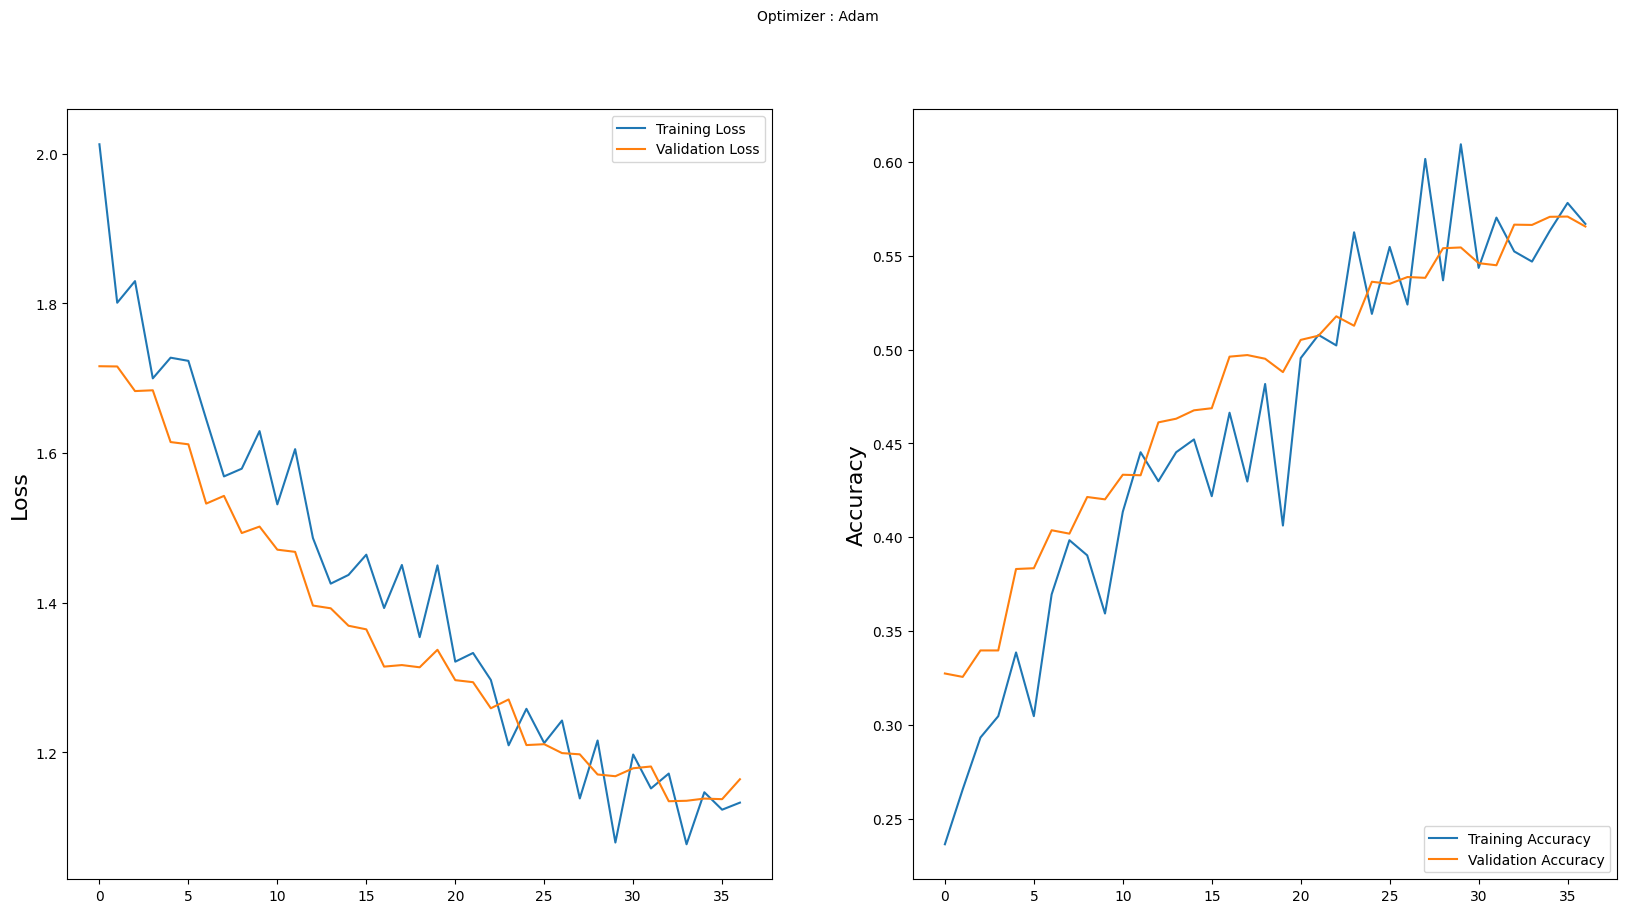

In [26]:
# plot the evolution of Loss and Accuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Updated key
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Updated key
plt.legend(loc='lower right')
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step
              precision    recall  f1-score   support

       angry       0.57      0.40      0.47       958
     disgust       0.42      0.42      0.42       111
        fear       0.56      0.16      0.24      1024
       happy       0.67      0.88      0.76      1774
     neutral       0.45      0.62      0.52      1233
         sad       0.44      0.46      0.45      1247
    surprise       0.75      0.69      0.72       831

    accuracy                           0.57      7178
   macro avg       0.55      0.52      0.51      7178
weighted avg       0.57      0.57      0.54      7178



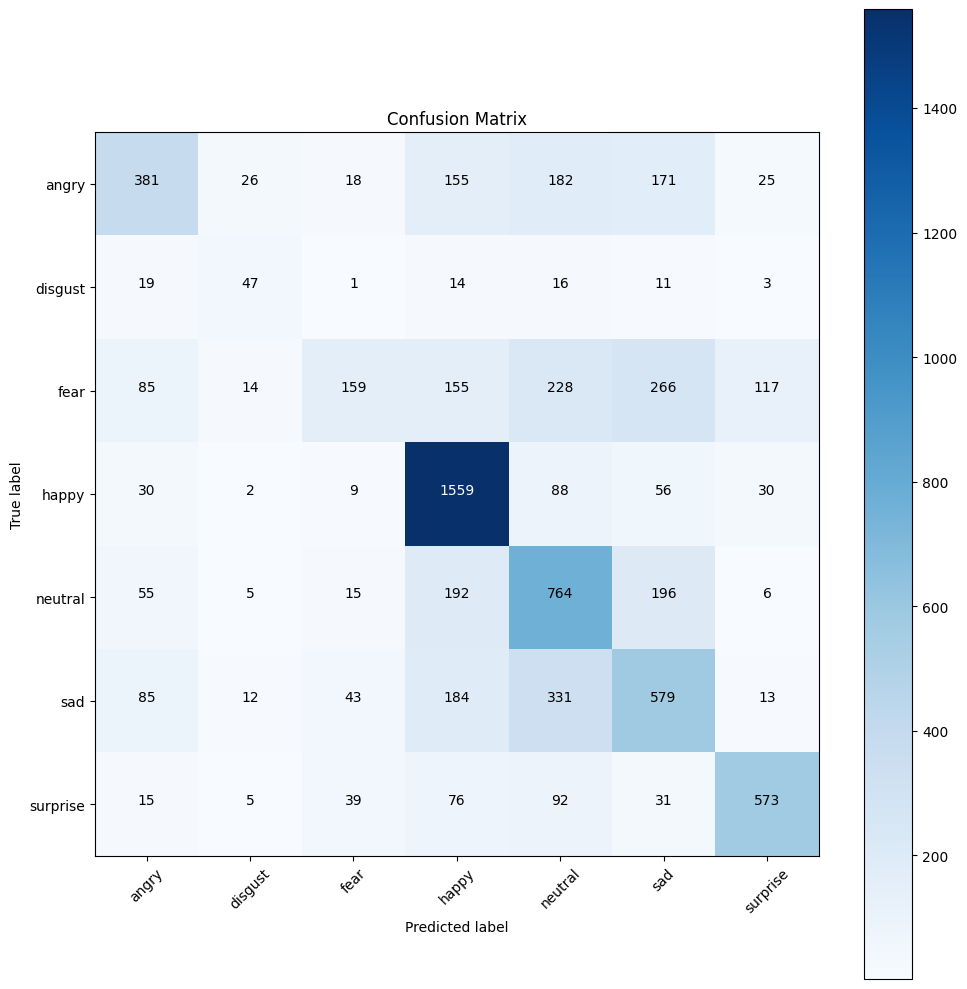

In [24]:
# compute predictions
predictions = model.predict(validation_generator)  # Use predict instead of predict_generator
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

# show the classification report
target_names = list(class_names)
print(classification_report(y_test, y_pred, target_names=target_names))

In [25]:
# save the model
model.save("FinalModel.h5")